In [14]:
import pandas as pd

from mlforecast import MLForecast
from mlforecast.utils import generate_daily_series, generate_prices_for_series
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from utilsforecast.plotting import plot_series

import lightgbm as lgb

# data

In [6]:
series = generate_daily_series(
    n_series=100,
    # max_length=300,
    equal_ends=True,
    n_static_features=2,
    static_as_categorical=False,
    with_trend = True,
).rename(columns = {"static_1": "product_id"})
print(series.head())
print()
print(series.shape)
print()
print(series["unique_id"].value_counts())

  unique_id         ds           y  static_0  product_id
0     id_00 2000-10-05   39.811983        79          45
1     id_00 2000-10-06  103.757103        79          45
2     id_00 2000-10-07  177.540923        79          45
3     id_00 2000-10-08  260.437170        79          45
4     id_00 2000-10-09  346.872764        79          45

(27003, 5)

id_46    499
id_35    498
id_72    492
id_34    481
id_83    480
        ... 
id_51     81
id_73     81
id_58     78
id_25     75
id_08     59
Name: unique_id, Length: 100, dtype: int64


In [19]:
prices_catalog = generate_prices_for_series(series)
print(prices_catalog.head())
print()
print(prices_catalog.shape)
print()
print(prices_catalog["unique_id"].value_counts())
print()
print(series.loc[series["unique_id"] == "id_08"])
print()
print(prices_catalog.loc[prices_catalog["unique_id"] == "id_08"])

          ds unique_id     price
0 2000-10-05     id_00  0.548814
1 2000-10-06     id_00  0.715189
2 2000-10-07     id_00  0.602763
3 2000-10-08     id_00  0.544883
4 2000-10-09     id_00  0.423655

(27703, 3)

id_46    506
id_35    505
id_72    499
id_34    488
id_83    487
        ... 
id_51     88
id_73     88
id_58     85
id_25     82
id_08     66
Name: unique_id, Length: 100, dtype: int64

     unique_id         ds           y  static_0  product_id
2056     id_08 2001-03-17  331.026336        62          73
2057     id_08 2001-03-18  395.310527        62          73
2058     id_08 2001-03-19   22.332969        62          73
2059     id_08 2001-03-20   74.562499        62          73
2060     id_08 2001-03-21  136.784995        62          73
2061     id_08 2001-03-22  224.273755        62          73
2062     id_08 2001-03-23  262.088918        62          73
2063     id_08 2001-03-24  324.256547        62          73
2064     id_08 2001-03-25  407.827962        62          73
20

In [8]:
series_with_prices = series.merge(prices_catalog, how = "left")
print(series_with_prices.head())
print()
print(series_with_prices.shape)
print()
print(series_with_prices["unique_id"].value_counts())

  unique_id         ds           y  static_0  product_id     price
0     id_00 2000-10-05   39.811983        79          45  0.548814
1     id_00 2000-10-06  103.757103        79          45  0.715189
2     id_00 2000-10-07  177.540923        79          45  0.602763
3     id_00 2000-10-08  260.437170        79          45  0.544883
4     id_00 2000-10-09  346.872764        79          45  0.423655

(27003, 6)

id_46    499
id_35    498
id_72    492
id_34    481
id_83    480
        ... 
id_51     81
id_73     81
id_58     78
id_25     75
id_08     59
Name: unique_id, Length: 100, dtype: int64


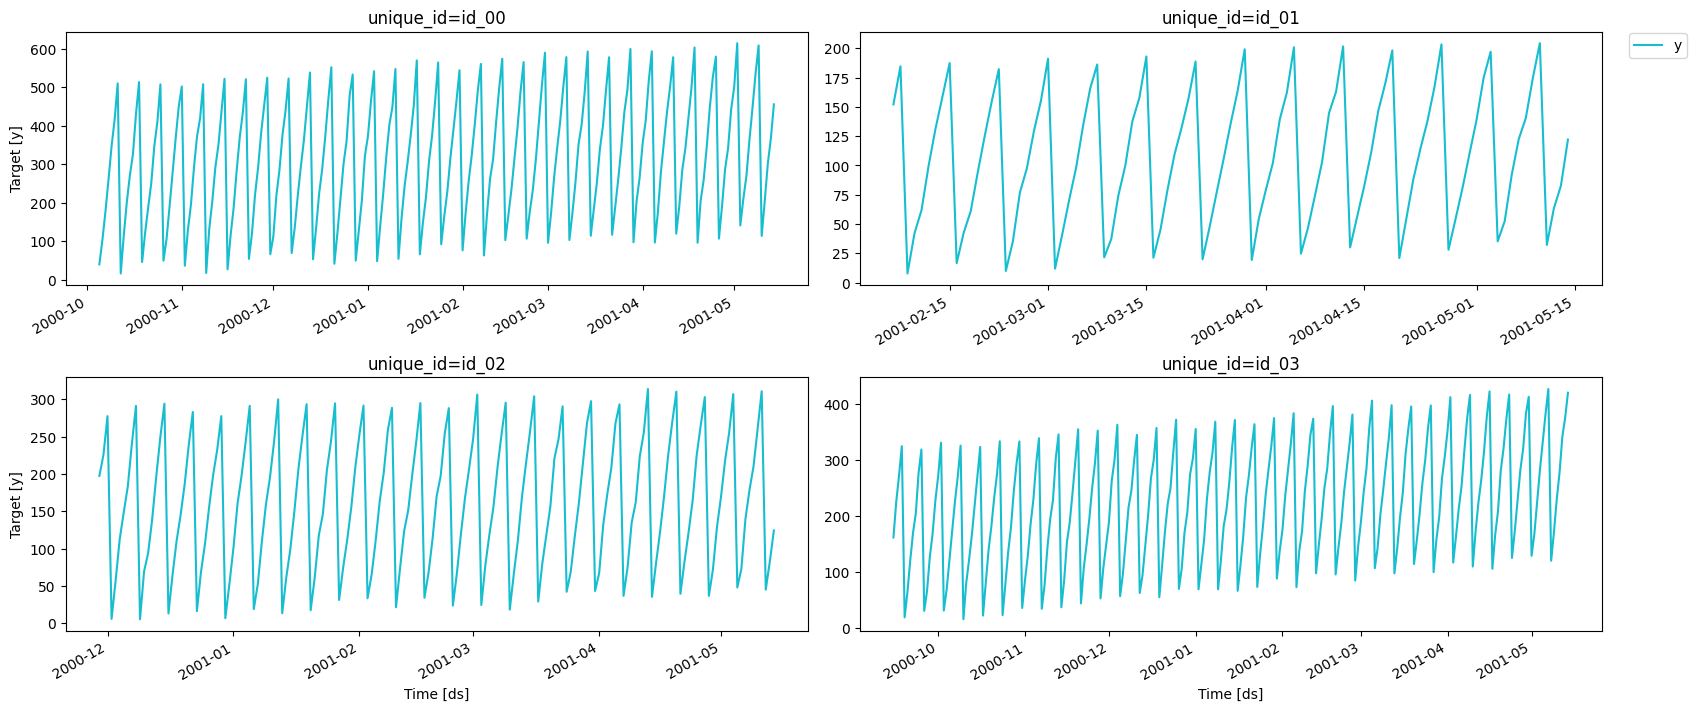

In [16]:
fig = plot_series(series_with_prices, max_ids = 4, plot_random = False)
fig

# model training

In [17]:
fcst = MLForecast(
    models = lgb.LGBMRegressor(n_jobs = 1, random_state = 0, verbosity = -1),
    freq = "D",
    lags = [7],
    lag_transforms={
        1: [ExpandingMean()],
        7: [RollingMean(window_size=14)],
    },
    date_features=["dayofweek", "month"],
    num_threads = 2,
)
fcst.fit(series_with_prices, static_features=["static_0", "product_id"])

MLForecast(models=[LGBMRegressor], freq=D, lag_features=['lag7', 'expanding_mean_lag1', 'rolling_mean_lag7_window_size14'], date_features=['dayofweek', 'month'], num_threads=2)

In [18]:
fcst.ts.features_order_

['static_0',
 'product_id',
 'price',
 'lag7',
 'expanding_mean_lag1',
 'rolling_mean_lag7_window_size14',
 'dayofweek',
 'month']

# model predicting

In [21]:
preds = fcst.predict(h = 7, X_df = prices_catalog)
print(preds.head())
print()
print(preds.shape)
print()
print(preds["unique_id"].value_counts())

  unique_id         ds  LGBMRegressor
0     id_00 2001-05-15     535.397707
1     id_00 2001-05-16     611.116803
2     id_00 2001-05-17     121.252977
3     id_00 2001-05-18     204.960144
4     id_00 2001-05-19     304.515885

(700, 3)

id_00    7
id_63    7
id_73    7
id_72    7
id_71    7
        ..
id_30    7
id_29    7
id_28    7
id_27    7
id_99    7
Name: unique_id, Length: 100, dtype: int64
